In [1]:
# %load make_walks_10.py
import random
import networkx as nx
import numpy as np
#from utilities import graphs
import matplotlib.pyplot as plt
import os
from scipy import stats
import pickle

random.seed()



In [2]:
#define graph link structure
_schapiro_list = {
    0: [1, 2, 3, 14],
    1: [0, 2, 3, 4],
    2: [0, 1, 3, 4],
    3: [0, 1, 2, 4],
    4: [1, 2, 3, 5],
    5: [4, 6, 7, 8],
    6: [5, 7, 8, 9],
    7: [5, 6, 8, 9],
    8: [5, 6, 7, 9],
    9: [6, 7, 8, 10],
    10: [9, 11, 12, 13],
    11: [10, 12, 13, 14],
    12: [10, 11, 13, 14],
    13: [10, 11, 12, 14],
    14: [11, 12, 13, 0]}

_lattice_list = {
    0: [1, 2, 3, 12],
    1: [0, 2, 4, 13],
    2: [0, 1, 5, 14],
    3: [0, 4, 5, 6],
    4: [1, 3, 5, 7],
    5: [2, 3, 4, 8],
    6: [3, 7, 8, 9],
    7: [4, 6, 8, 10],
    8: [5, 6, 7, 11],
    9: [6, 10, 11, 12],
    10: [7, 9, 11, 13],
    11: [8, 9, 10, 14],
    12: [0, 9, 13, 14],
    13: [1, 10, 12, 14],
    14: [2, 11, 12, 13]}

_ring_lattice_list = {
    0: [13, 14, 1, 2],
    1: [14, 0, 2, 3],
    2: [0, 1, 3, 4],
    3: [1, 2, 4, 5],
    4: [2, 3, 5, 6],
    5: [3, 4, 6, 7],
    6: [4, 5, 7, 8],
    7: [5, 6, 8, 9],
    8: [6, 7, 9, 10],
    9: [7, 8, 10, 11],
    10: [8, 9, 11, 12],
    11: [9, 10, 12, 13],
    12: [10, 11, 13, 14],
    13: [11, 12, 14, 0],
    14: [12, 13, 0, 1],
}

# for 10 nodes
_schapiro10_list = {
    0: [1, 2, 3, 9],
    1: [0, 2, 3, 4],
    2: [0, 1, 3, 4],
    3: [0, 1, 2, 4],
    4: [1, 2, 3, 5],
    5: [4, 6, 7, 8],
    6: [5, 7, 8, 9],
    7: [5, 6, 8, 9],
    8: [5, 6, 7, 9],
    9: [6, 7, 8, 0]}

_ring_lattice10_list = {
    0: [8, 9, 1, 2],
    1: [9, 0, 2, 3],
    2: [0, 1, 3, 4],
    3: [1, 2, 4, 5],
    4: [2, 3, 5, 6],
    5: [3, 4, 6, 7],
    6: [4, 5, 7, 8],
    7: [5, 6, 8, 9],
    8: [6, 7, 9, 0],
    9: [7, 8, 0, 1]

}

lattice = nx.from_dict_of_lists(_lattice_list)
schapiro = nx.from_dict_of_lists(_schapiro_list)
ring_lattice = nx.from_dict_of_lists(_ring_lattice_list)

ring_lattice10 = nx.from_dict_of_lists(_ring_lattice10_list)
schapiro10 = nx.from_dict_of_lists(_schapiro10_list)



In [3]:
# Add edges
schapiro10_wei_uni = nx.DiGraph()
schapiro10_wei_uni.add_edges_from([(1,2), (2,1), (7,8), (8,7), (6,7), (3,2), (0,3), (4,3), (5,6), (9,6)], weight=0.4)
schapiro10_wei_uni.add_edges_from([(1,3), (3,1), (6,8), (8,6), (7,6), (2,3), (0,2), (4,2), (5,7), (9,7)], weight=0.1)
schapiro10_wei_uni.add_edges_from([(1,0), (2,0), (3,0), (0,9), (9,0), (0,1), (9,8),
                               (1,4), (2,4), (3,4), (4,5), (5,4), (4,1), (5,8),
                               (6,9), (6,5), (7,5), (7,9), 
                               (8,5), (8,9),], weight=0.25)
edges = schapiro10_wei_uni.edges
colors = []
for e in edges:
    colors.append(schapiro10_wei_uni.get_edge_data(e[0],e[1]).get('weight'))
    
list(schapiro10_wei_uni.edges(data='weight'))

[(0, 9, 0.25),
 (0, 2, 0.1),
 (0, 3, 0.4),
 (0, 1, 0.25),
 (1, 0, 0.25),
 (1, 2, 0.4),
 (1, 3, 0.1),
 (1, 4, 0.25),
 (2, 0, 0.25),
 (2, 1, 0.4),
 (2, 3, 0.1),
 (2, 4, 0.25),
 (3, 0, 0.25),
 (3, 1, 0.1),
 (3, 2, 0.4),
 (3, 4, 0.25),
 (4, 1, 0.25),
 (4, 2, 0.1),
 (4, 3, 0.4),
 (4, 5, 0.25),
 (5, 8, 0.25),
 (5, 4, 0.25),
 (5, 6, 0.4),
 (5, 7, 0.1),
 (6, 8, 0.1),
 (6, 9, 0.25),
 (6, 5, 0.25),
 (6, 7, 0.4),
 (7, 8, 0.4),
 (7, 9, 0.25),
 (7, 5, 0.25),
 (7, 6, 0.1),
 (8, 9, 0.25),
 (8, 5, 0.25),
 (8, 6, 0.1),
 (8, 7, 0.4),
 (9, 0, 0.25),
 (9, 8, 0.25),
 (9, 6, 0.4),
 (9, 7, 0.1)]

In [4]:
# Add edges
schapiro10_wei = nx.DiGraph()
schapiro10_wei.add_edges_from([(1,2), (2,1), (7,8), (8,7), (6,7), (3,2)], weight=0.4)
schapiro10_wei.add_edges_from([(1,3), (3,1), (6,8), (8,6), (7,6), (2,3)], weight=0.1)
schapiro10_wei.add_edges_from([(1,0), (2,0), (3,0), (0,9), (9,0), (0,1), (9,8), (0,3), (0,2), (4,3),
                               (1,4), (2,4), (3,4), (4,5), (5,4), (4,1), (5,8), (4,2), (5,7), (9,7),
                               (6,9), (6,5), (7,5), (7,9), (5,6), (9,6),
                               (8,5), (8,9),], weight=0.25)
edges = schapiro10_wei.edges
colors = []
for e in edges:
    colors.append(schapiro10_wei.get_edge_data(e[0],e[1]).get('weight'))
    
list(schapiro10_wei.edges(data='weight'))

[(0, 9, 0.25),
 (0, 2, 0.25),
 (0, 3, 0.25),
 (0, 1, 0.25),
 (1, 0, 0.25),
 (1, 2, 0.4),
 (1, 3, 0.1),
 (1, 4, 0.25),
 (2, 0, 0.25),
 (2, 1, 0.4),
 (2, 3, 0.1),
 (2, 4, 0.25),
 (3, 0, 0.25),
 (3, 1, 0.1),
 (3, 2, 0.4),
 (3, 4, 0.25),
 (4, 1, 0.25),
 (4, 2, 0.25),
 (4, 3, 0.25),
 (4, 5, 0.25),
 (5, 8, 0.25),
 (5, 4, 0.25),
 (5, 6, 0.25),
 (5, 7, 0.25),
 (6, 8, 0.1),
 (6, 9, 0.25),
 (6, 5, 0.25),
 (6, 7, 0.4),
 (7, 8, 0.4),
 (7, 9, 0.25),
 (7, 5, 0.25),
 (7, 6, 0.1),
 (8, 9, 0.25),
 (8, 5, 0.25),
 (8, 6, 0.1),
 (8, 7, 0.4),
 (9, 0, 0.25),
 (9, 8, 0.25),
 (9, 6, 0.25),
 (9, 7, 0.25)]

In [5]:
pos=nx.spring_layout(schapiro10_wei) # positions for all nodes
pos

labels={}
labels[0]=r'$0$'
labels[1]=r'$1$'
labels[2]=r'$2$'
labels[3]=r'$3$'
labels[4]=r'$4$'
labels[5]=r'$5$'
labels[6]=r'$6$'
labels[7]=r'$7$'
labels[8]=r'$8$'
labels[9]=r'$9$'


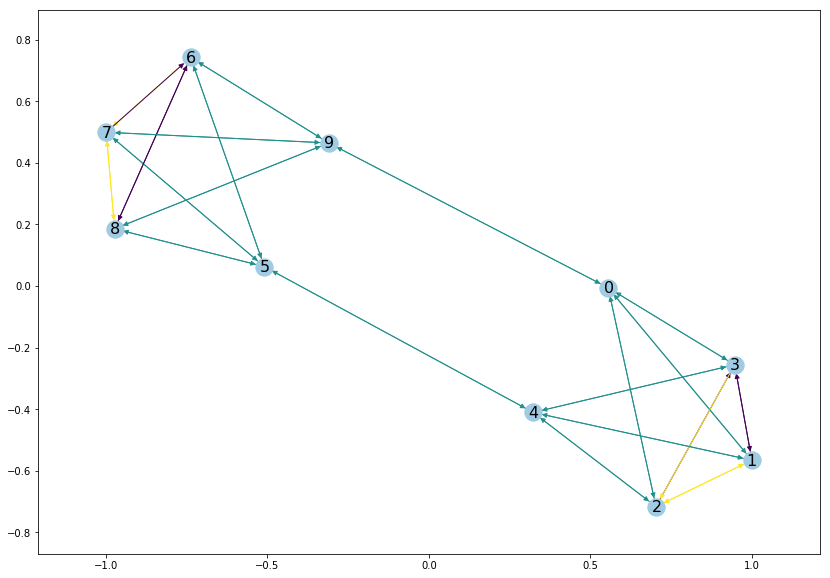

In [6]:
fig = plt.figure(figsize=(14,10))

# nodes
nx.draw_networkx_nodes(schapiro10_wei,pos,node_color='#A0CBE2', with_labels=True)

# edges
nx.draw_networkx_edges(schapiro10_wei,pos,edge_color=colors)

#labels
nx.draw_networkx_labels(schapiro10_wei,pos,labels,font_size=16)

plt.show()

In [7]:
########
# WALKS functions
########
def random_walk(G, n):
    node = random.choice(list(G.nodes()))
    walk = [node]
    for i in range(n - 1):
        node = random.choice(list(G[node].keys()))
        walk.append(node)
    return walk

def random_walk_wei(G, n):
    node = random.choice(list(G.nodes()))
    walk = [node]
    for i in range(n - 1):
        edges = list(G.edges(node, data='weight'))
        node_opt = [e[1] for e in edges]
        weight_opt = [e[2] for e in edges]
        node = np.random.choice(node_opt,p=weight_opt)
        walk.append(node)
    return walk

def hamiltonian_walk(n):
    """
    Generates a hamiltonian walk for the modular graph
    """
    def make_single_traversal(starting_node, reverse):
        traversal = [0]

        block = [1,2,3]
        random.shuffle(block)
        traversal += block
        traversal += [4,5]

        block = [6,7,8]
        random.shuffle(block)
        traversal += block
        traversal += [9,10]

        block = [11,12,13]
        random.shuffle(block)
        traversal += block
        traversal += [14]

        # reverse traversal
        if reverse:
            traversal = traversal[::-1]

        # set a non-zero starting node
        ind = np.where([x == starting_node for x in traversal])[0][0]
        traversal = traversal[ind:] + traversal[:ind]

        return traversal

    reverse = random.choice([True, False])
    starting_node = random.choice(range(15))
    walk = make_single_traversal(starting_node, reverse)

    while len(walk) < n:
        current_node = walk[-1]
        reverse = random.choice([True, False])
        next_node = random.choice(graphs.schapiro[current_node].keys())
        walk.extend(make_single_traversal(next_node, reverse))

    return walk[:n]

def find_valid_jumps(G):
    """
    Given a graph, return a dictionary of nodes,
    listing all nodes at least 3 nodes away from that node
    """
    path_lengths = nx.shortest_paths.shortest_path_length(G)
    valid_jumps = {}
    for n, dists in path_lengths:
        valid_jumps[n] = [k for k, v in dists.items() if v == 3]
    return valid_jumps


def random_walk_with_jumps(G, n_steps, n_jumps, min_dist=10, valid_jumps=None):
    """
    Generate <n_jumps> blocks of at least <min_dist + 1> connected nodes.

    Each block begins with a jump, and then the remaining <min_dist> nodes
    are all sequential.

    Blocks all begin at <min_dist + 1> length, and remaining steps in the walk
    are randomly added on.
    """
    spaces = np.ones(n_jumps, dtype=np.int) * (min_dist + 1)  # jump + <min_dist> correct transitions
    spaces = np.append(spaces, 1)  # Need to have a block of at least one node (the jump itself)
    remaining_nodes = n_steps - np.sum(spaces)

    if not valid_jumps:
        valid_jumps = find_valid_jumps(G)

    if remaining_nodes < 0:
        raise ValueError('Invalid input combination: not enough nodes')

    for i in range(remaining_nodes):
        x = np.random.choice(range(len(spaces)))
        spaces[x] += 1

    node = random.choice(G.nodes().keys())
    walk = [node]
    is_jump = [False]
    for i, block_length in enumerate(spaces):
        if i > 0:
            node = random.choice(valid_jumps[node])
            walk.append(node)
            is_jump.append(True)
        for j in range(block_length - 1):
            node = random.choice(G[node].keys())
            walk.append(node)
            is_jump.append(False)
    return (walk, is_jump)


def get_jump_distribution(jumps):
    from collections import Counter
    idx = np.where(jumps)[0]
    return Counter(idx[1:] - idx[:-1])


def plot_distribution(jumps):
    import matplotlib.pyplot as plt
    dist = get_jump_distribution(jumps)
    vals = np.zeros(np.max(dist.keys()) + 1)
    for k, v in dist.iteritems():
        vals[k] = v
    plt.plot(vals)
    plt.show()


# def std_walk_with_jumps():
#     G = generate_random_graphs(100)
#     G = representative_graphs(G)
#     G = random.choice(G)
#     return walk_with_jumps(G, 1400, 40)


# def choose_random_graph():
#     graphs = representative_graphs(1000)
#     G = random.choice(graphs)
#     return G

#%%


In [61]:
list(schapiro10_wei.edges(0, data='weight'))

[(0, 9, 0.25), (0, 2, 0.1), (0, 3, 0.4), (0, 1, 0.25)]

/Users/stiso/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


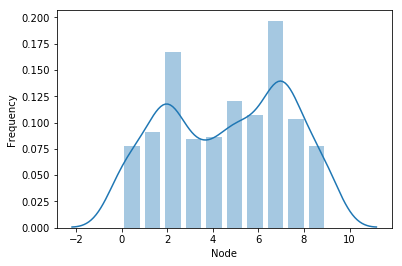

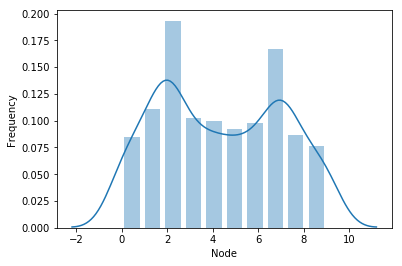

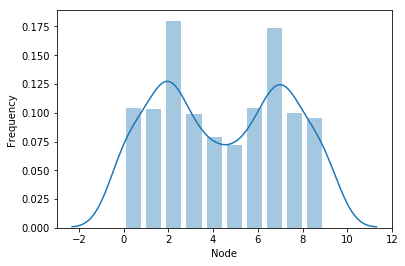

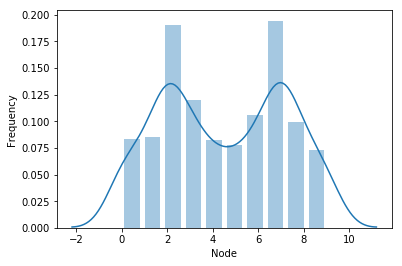

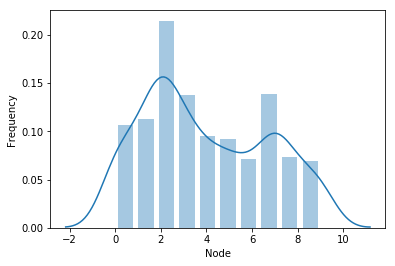

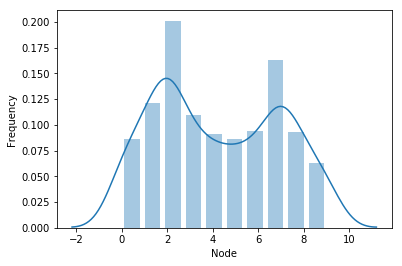

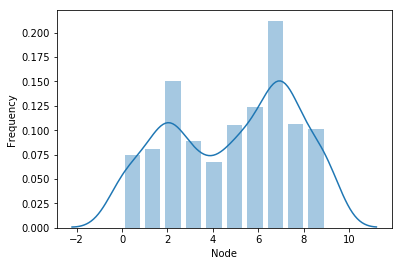

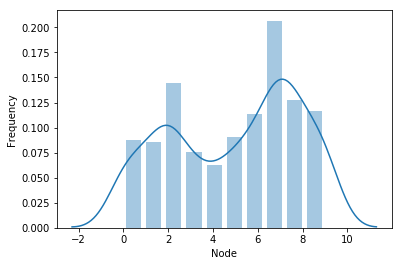

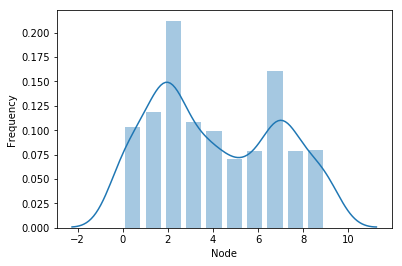

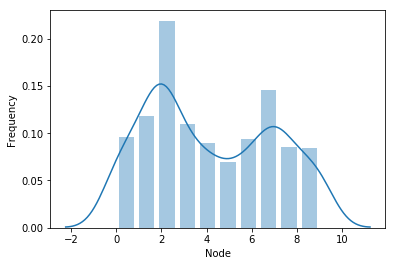

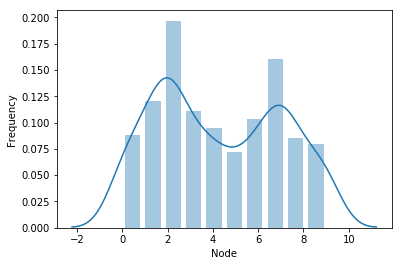

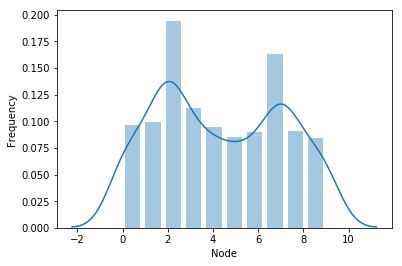

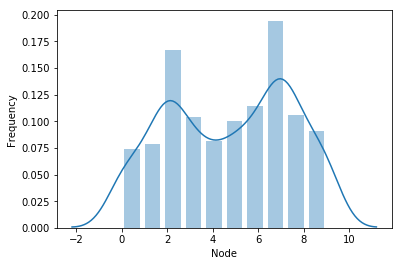

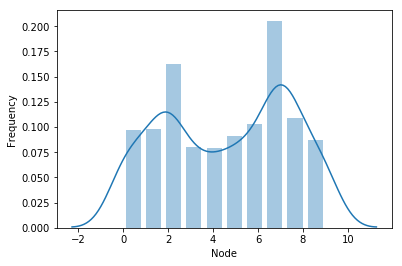

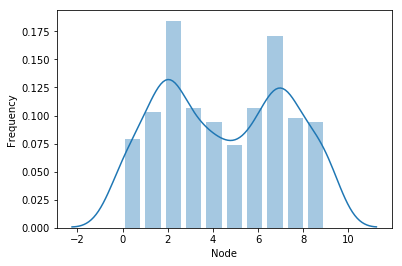

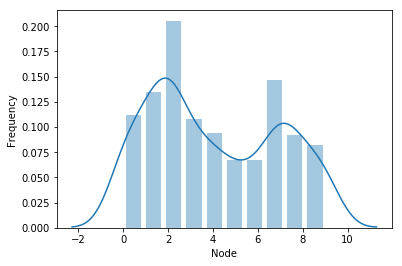

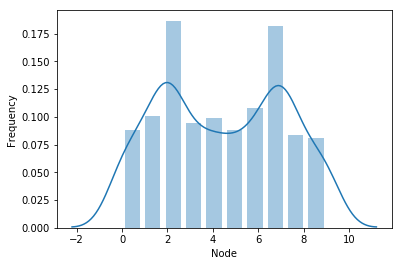

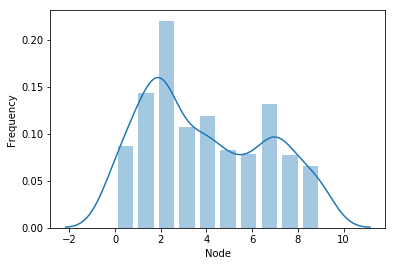

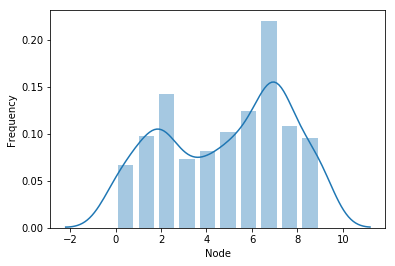

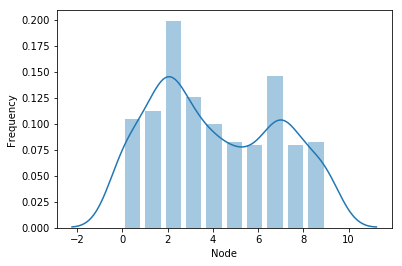

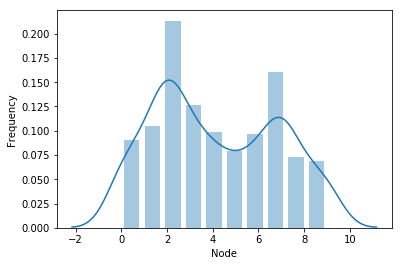

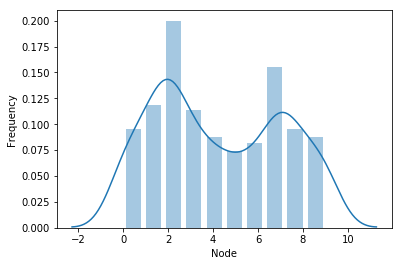

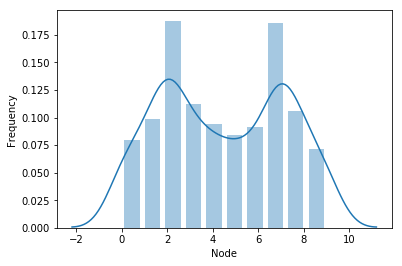

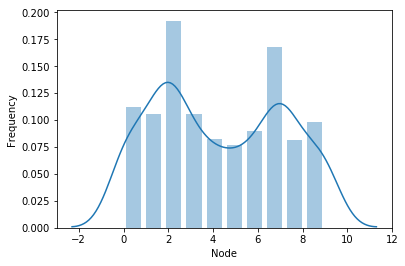

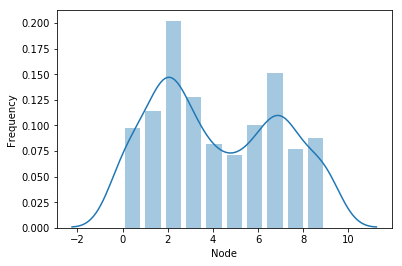

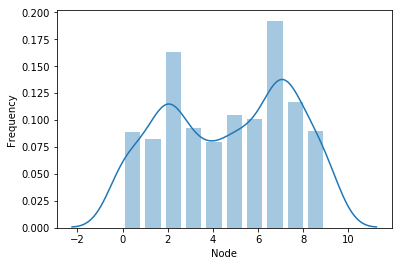

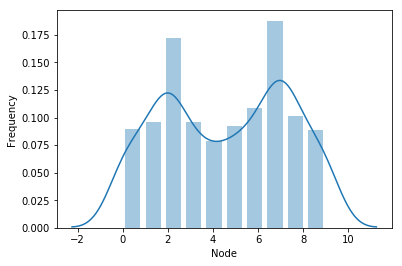

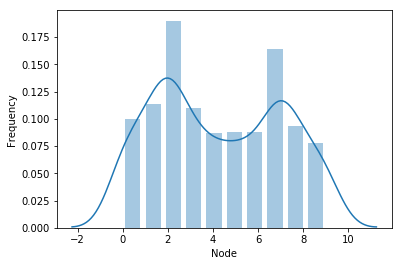

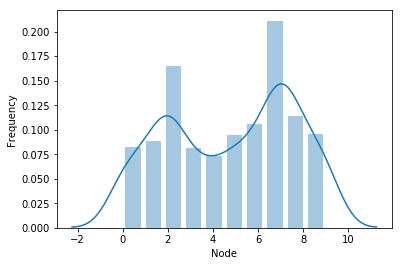

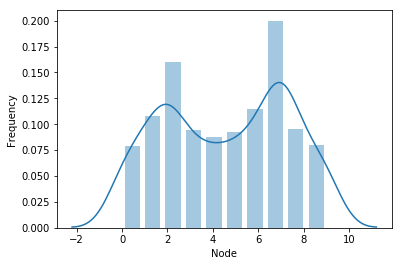

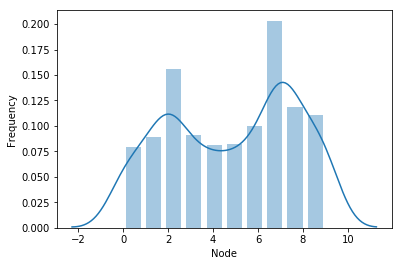

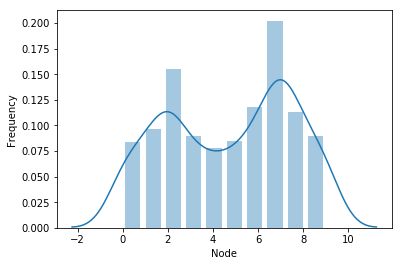

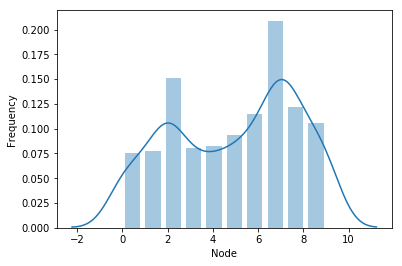

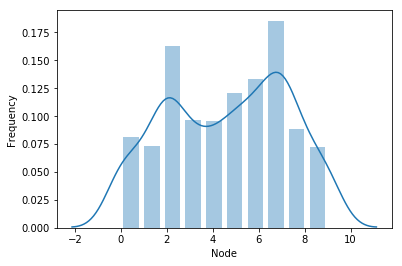

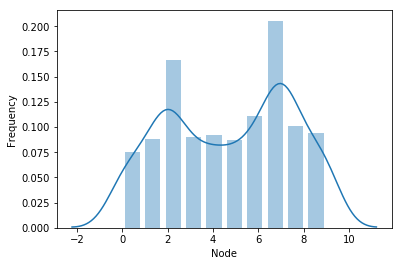

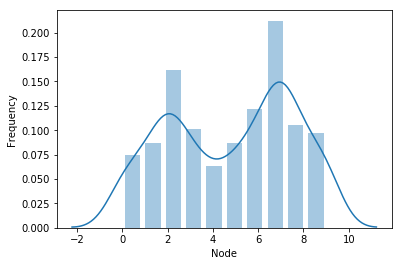

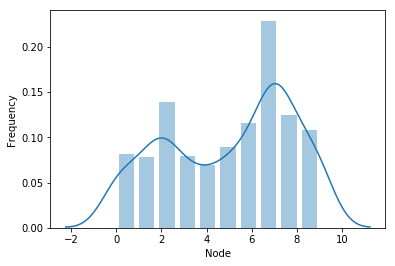

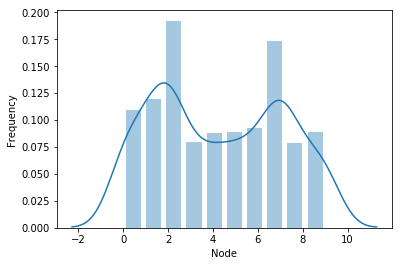

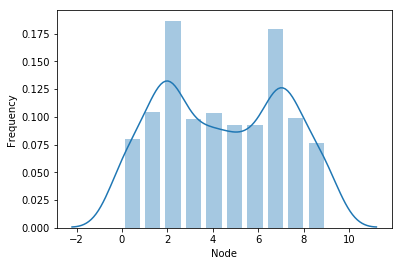

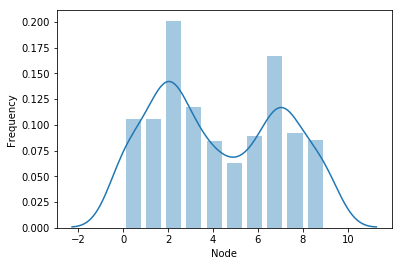

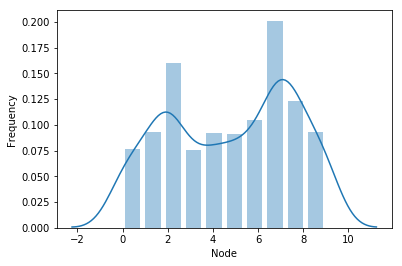

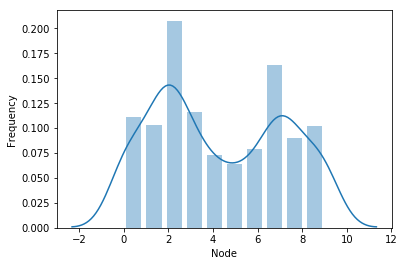

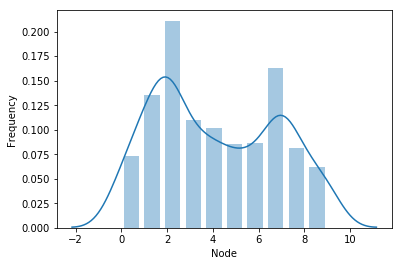

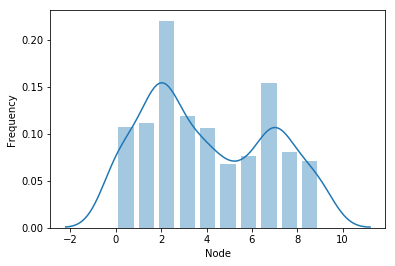

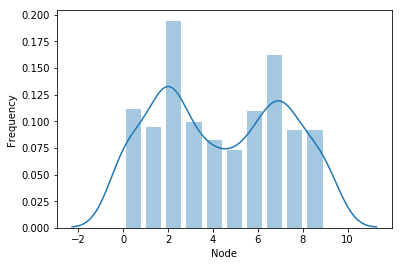

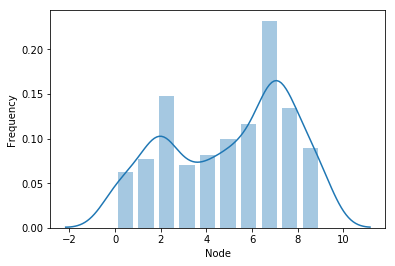

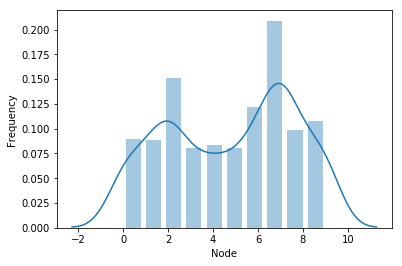

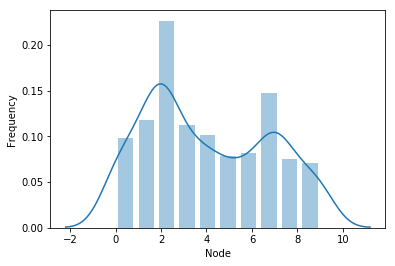

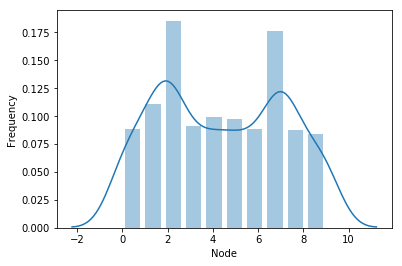

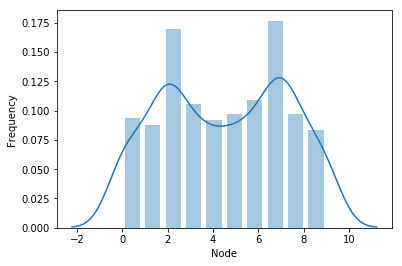

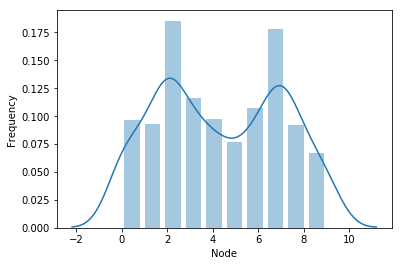

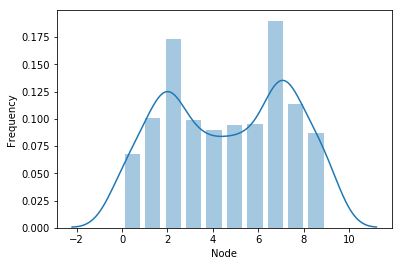

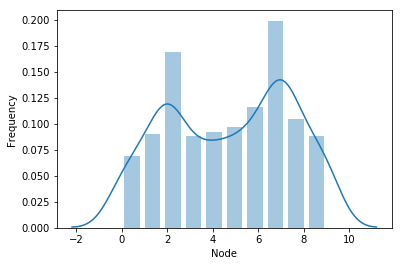

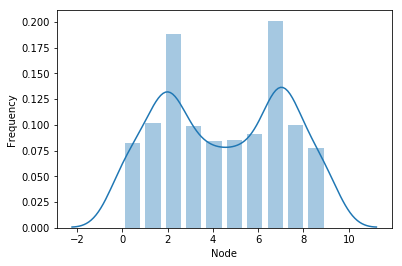

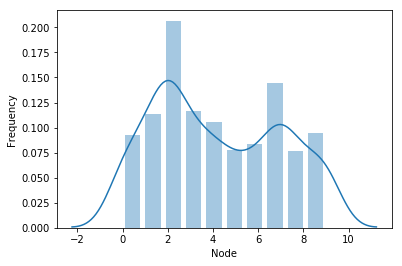

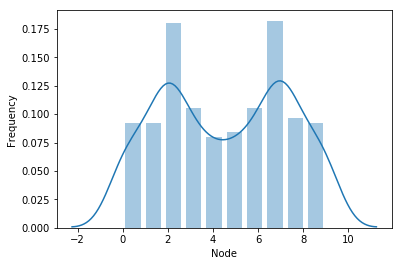

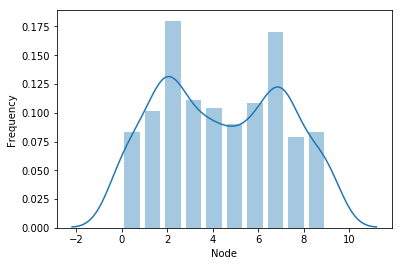

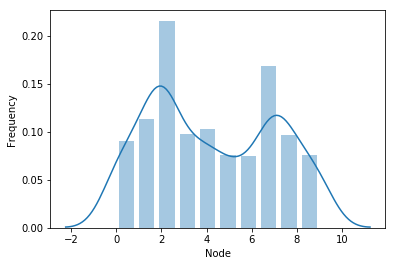

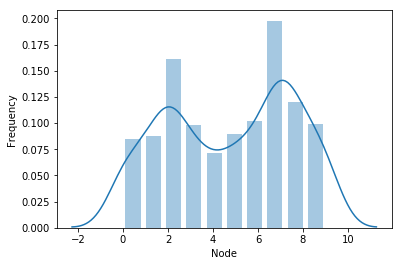

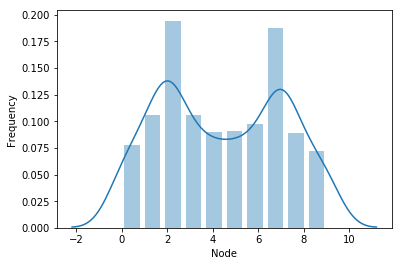

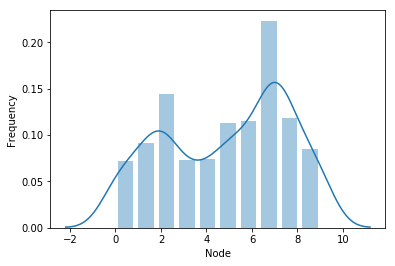

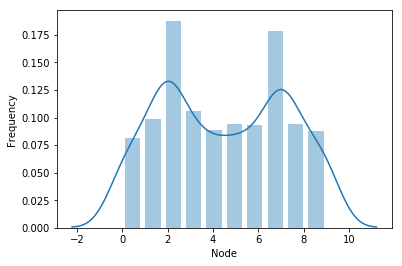

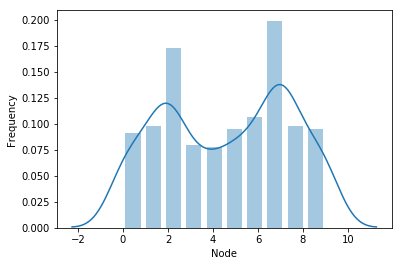

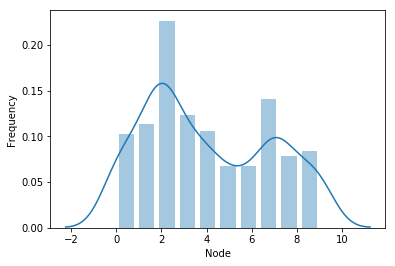

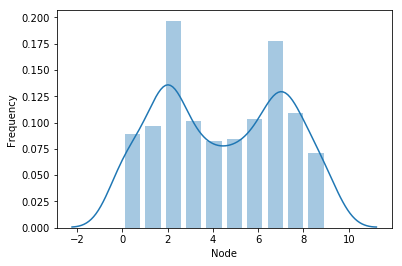

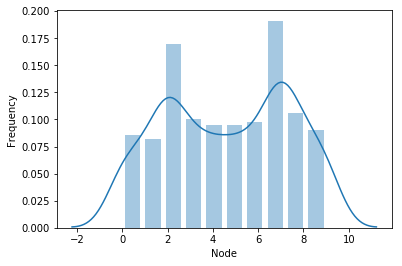

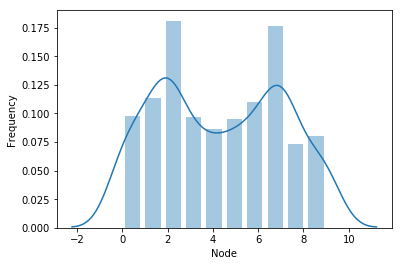

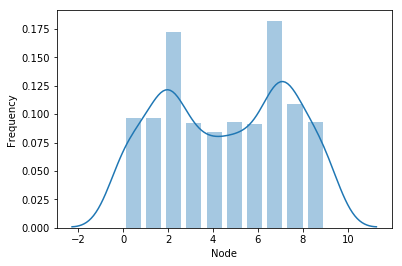

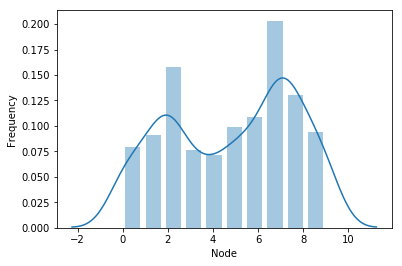

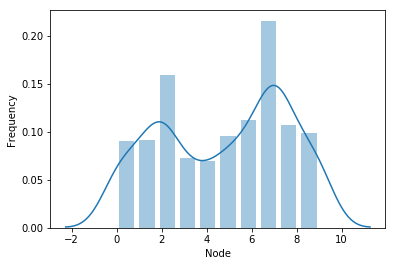

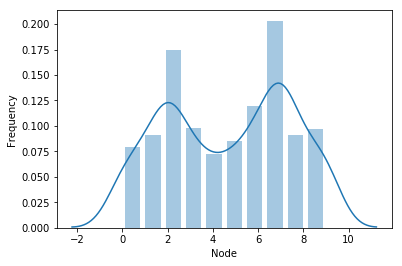

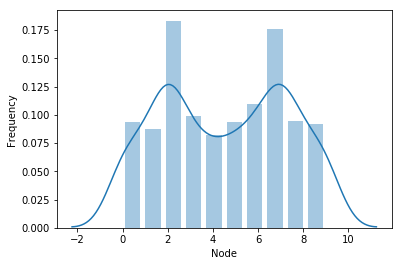

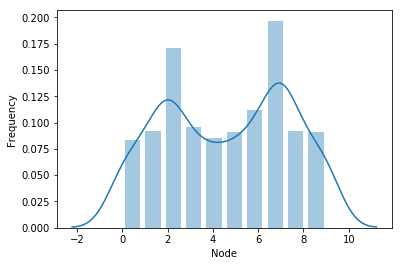

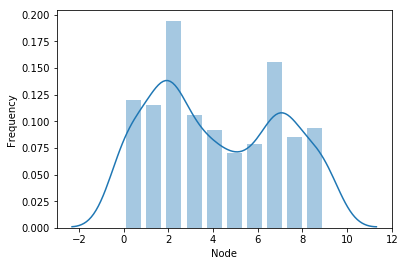

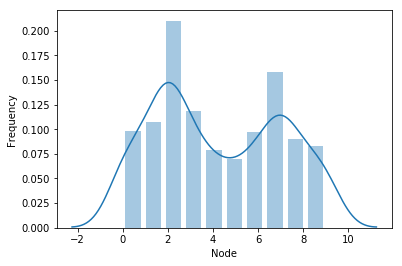

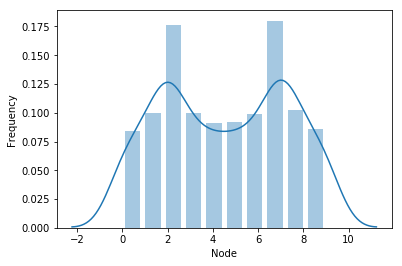

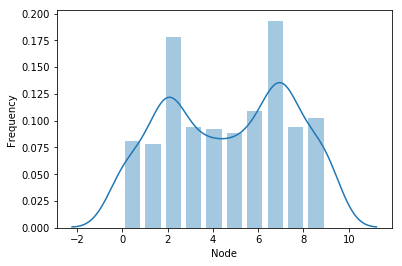

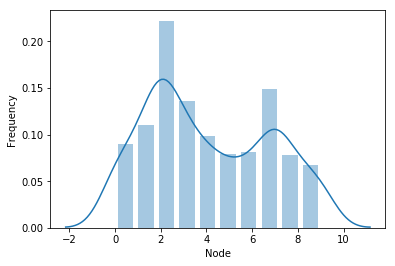

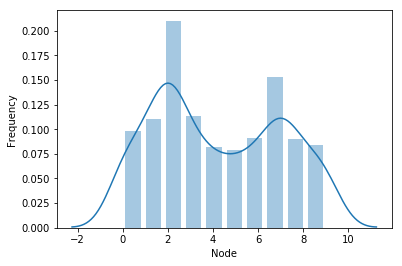

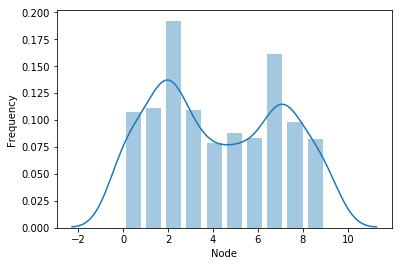

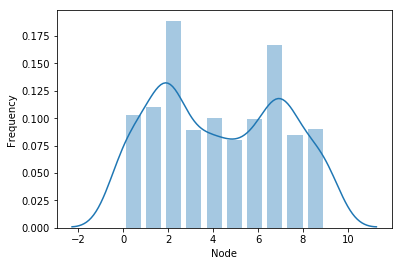

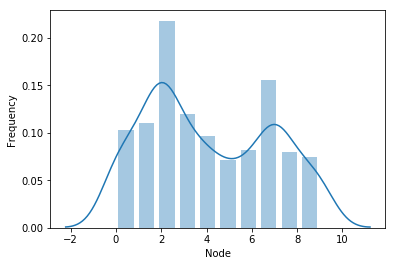

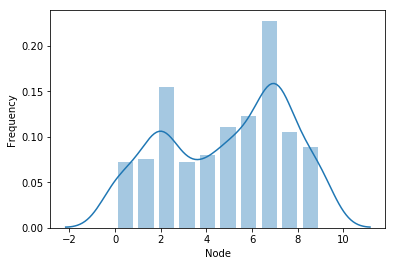

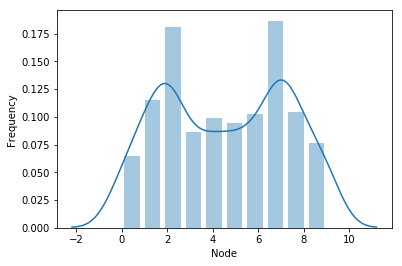

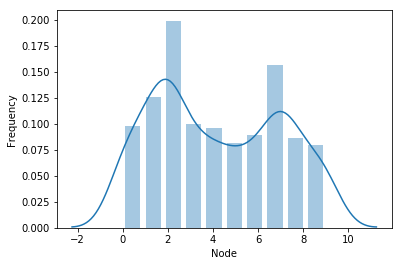

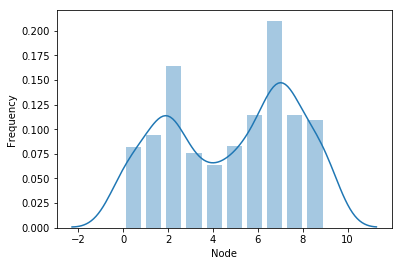

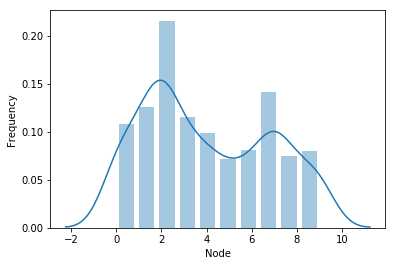

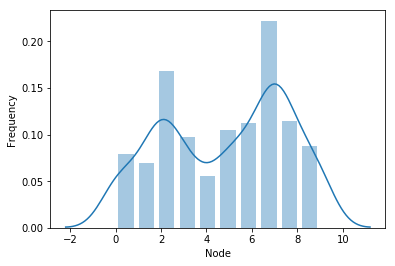

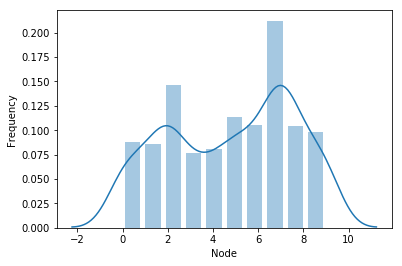

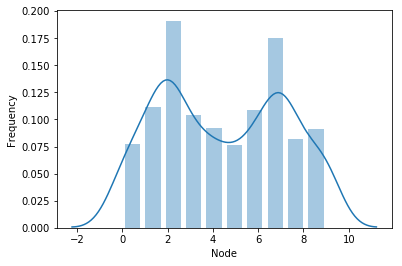

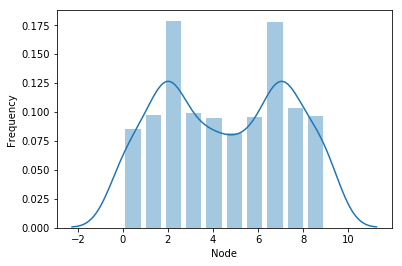

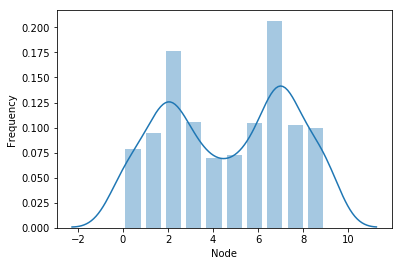

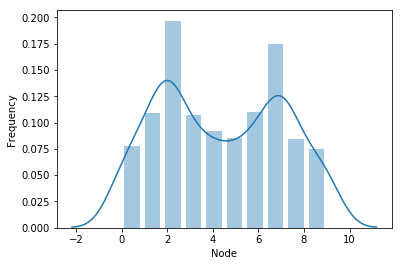

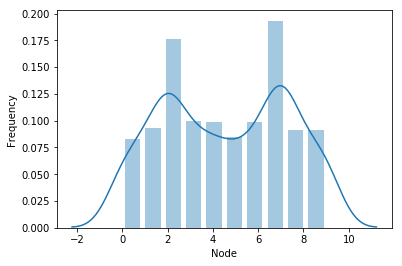

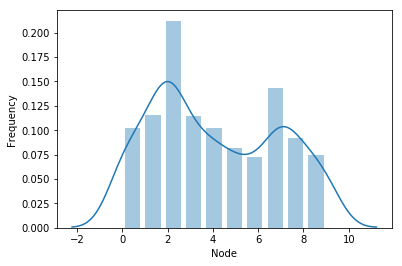

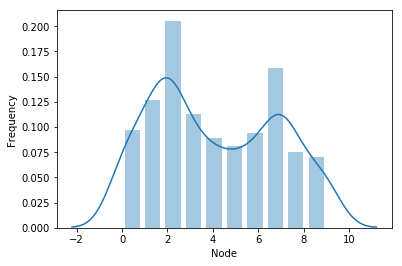

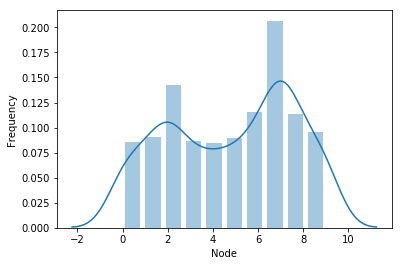

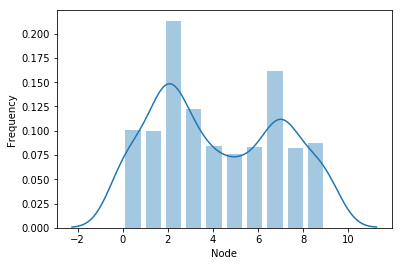

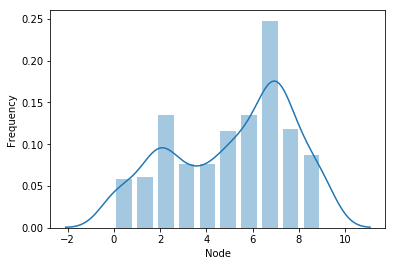

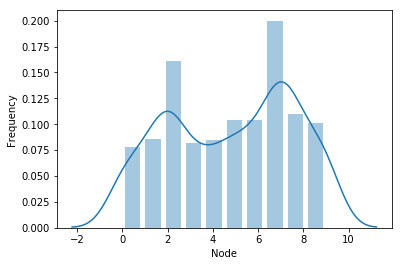

In [12]:
########################
 #   MAKE THE WALK CSVS
 #########################
 
# For one subject, generate either a random of modular graph
nTrial = 1000 # number of trials * number of sessions
import csv
import seaborn as sns
nSubj = 100
graph_uni = []
csvfiles = ["/Users/stiso/Documents/Python/graphLearning/mTurk-10-trans-prob/experiment/stims/modular10wei2.csv"]
ext = ['mod_wei2']
graphs = [schapiro10_test]
wei_flag = [1]

for j,fi in enumerate(csvfiles):
    for i in range(nSubj):
        if wei_flag[j]:
            walks = random_walk_wei(graphs[j],nTrial)
        else:
            walks = random_walk(graphs[j],nTrial)
        # save p-value indicating uniformity of walk
        graph_uni.append(stats.kstest(walks, stats.uniform(loc=0.0, scale=9.0).cdf)[0])
    
        # write to csv
        if i == 0 and os.path.isfile(fi):
            # hacky way to get around the fact that I am adding to existing files, and not overwriting them. 
            #Fix this later?
            raise NameError("You have already created walks for this graph. If you would like to make new ones, delete the csv file and try again")

        # plot and save histogram of walk
        fig = plt.figure()
        sns.distplot(walks, bins=10, hist_kws={"rwidth":0.75})
        plt.xlabel('Node')
        plt.ylabel('Frequency')
        plt.savefig("".join(['/Users/stiso/Documents/Python/graphLearning/images/', str(i), ext[j], '.png']))
    
        with open(fi, "a") as fp:
            wr = csv.writer(fp, dialect='excel')
            wr.writerow(walks)
    
          

    # Saving the stats about how uniform edge distribution is:
    with open("".join(['/Users/stiso/Documents/Python/graphLearning/uniformity', ext[j], '.pkl']), 'w') as f:  # Python 3: open(..., 'wb')
        pickle.dump([graph_uni], f)


# EDA with graphs

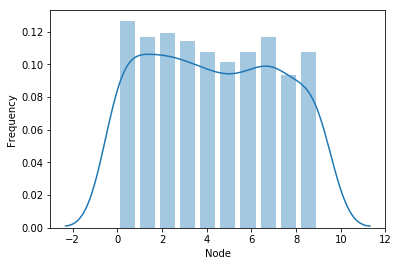

In [229]:
import seaborn as sns
walks = random_walk_wei(schapiro10_wei_uni,1000)
fig = plt.figure()
sns.distplot(walks, bins=10, hist_kws={"rwidth":0.75})
plt.xlabel('Node')
plt.ylabel('Frequency')
plt.savefig("".join(['/Users/stiso/Documents/Python/graphLearning/images/converge_hist.png']))


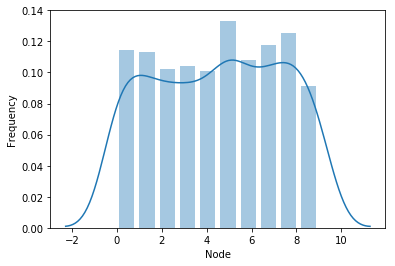

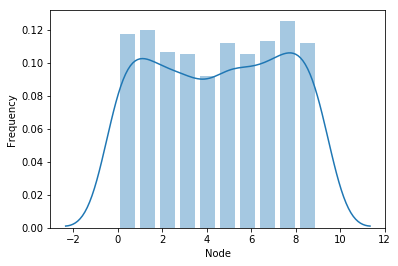

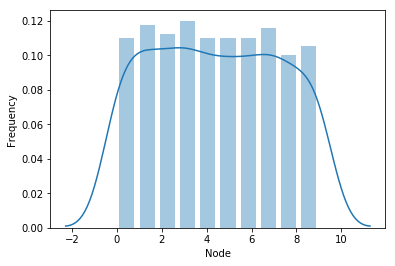

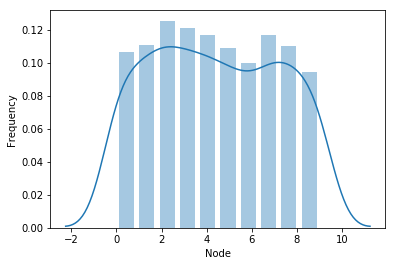

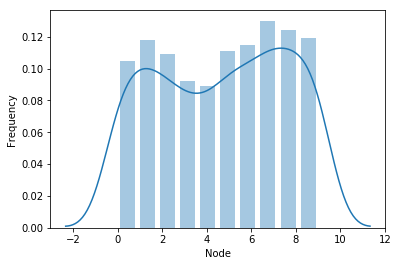

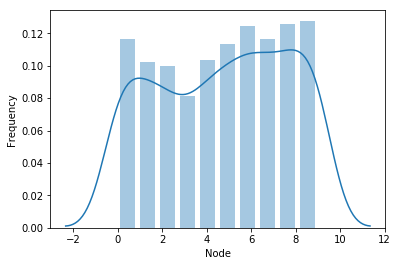

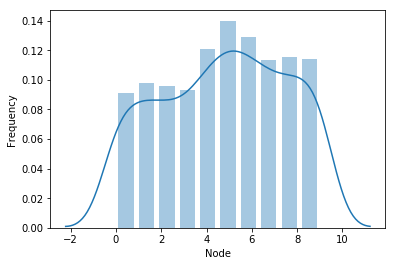

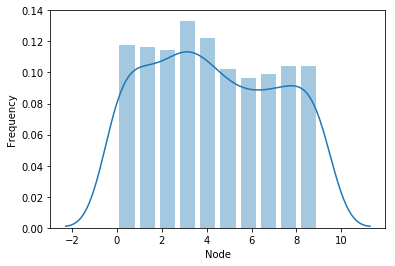

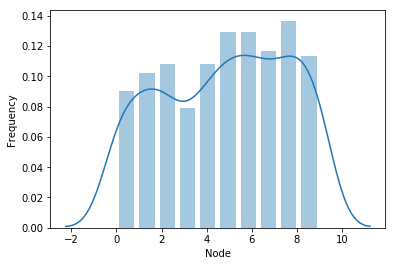

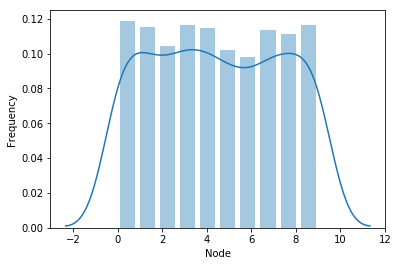

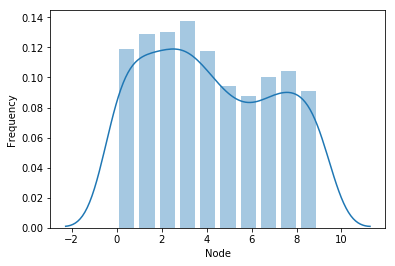

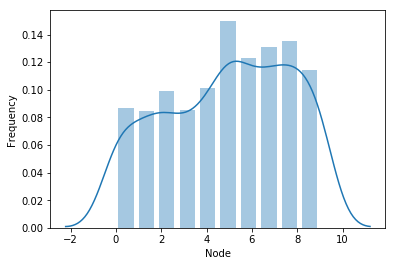

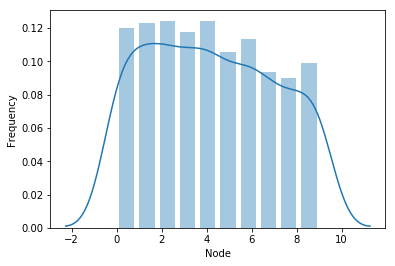

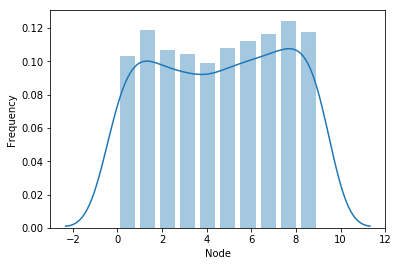

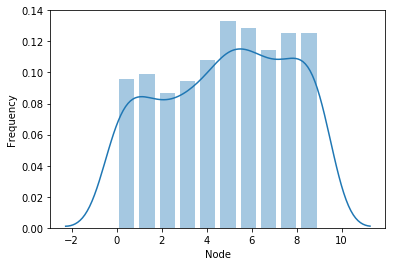

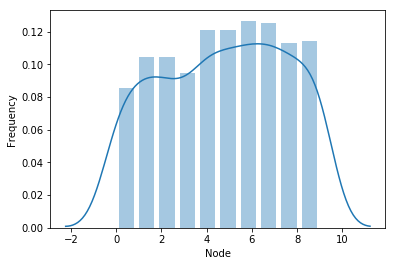

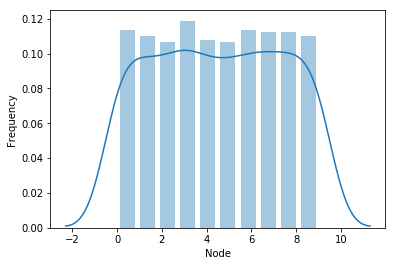

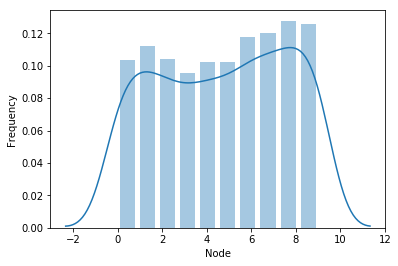

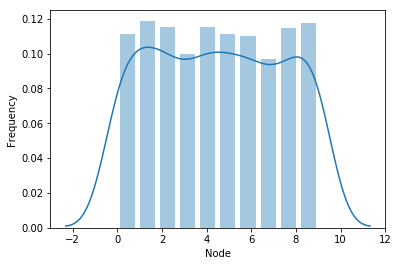

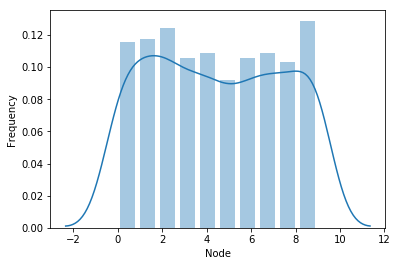

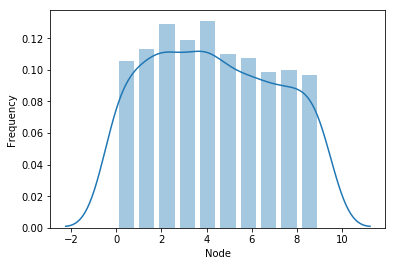

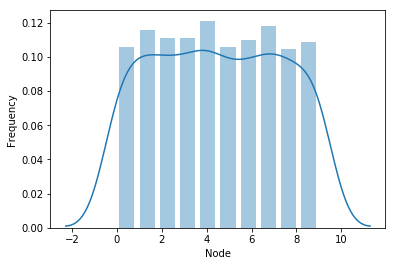

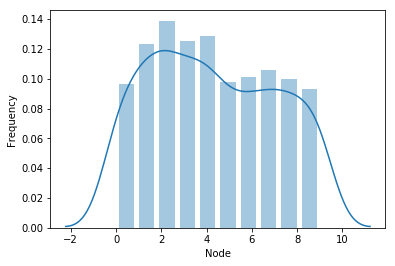

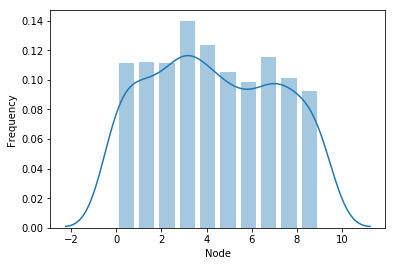

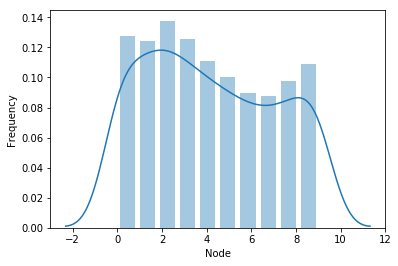

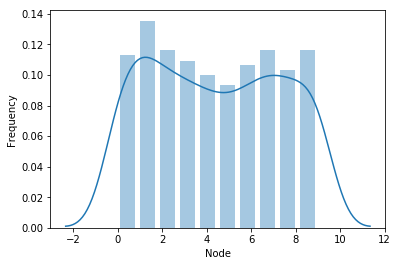

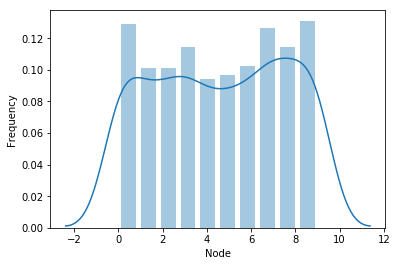

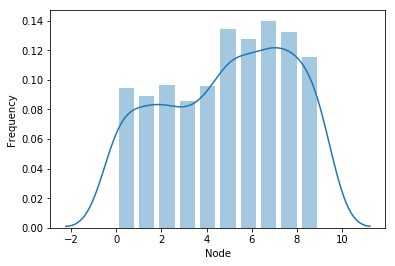

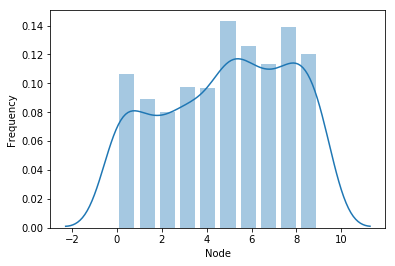

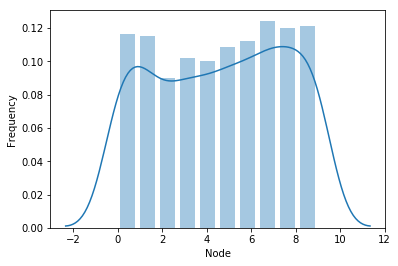

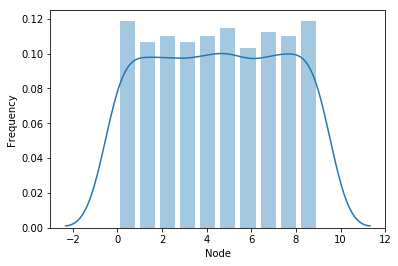

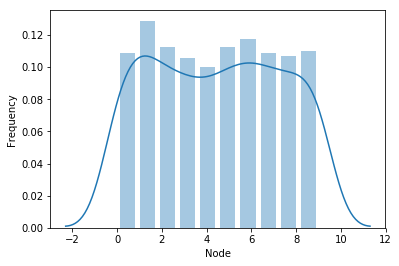

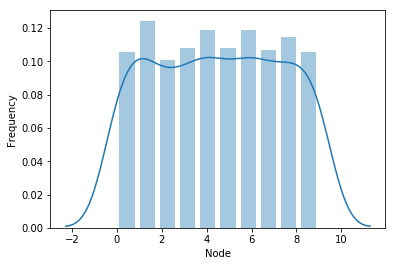

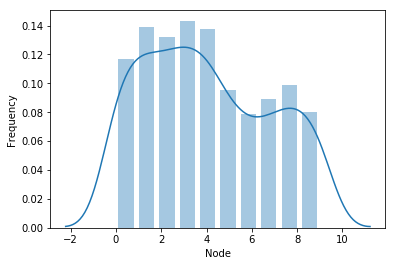

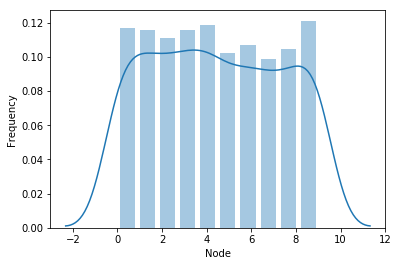

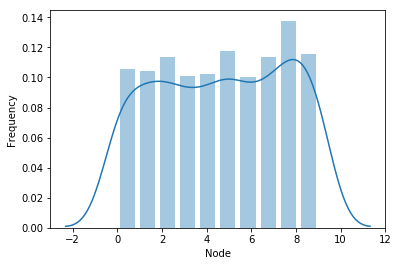

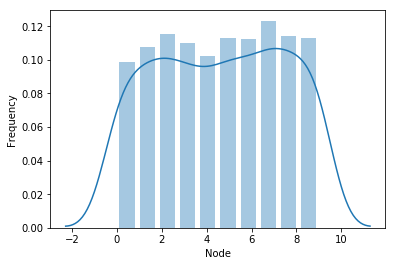

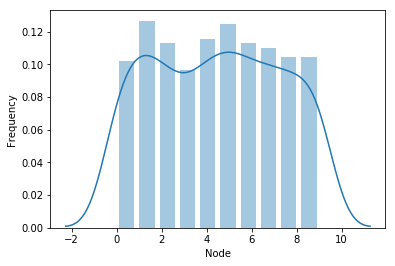

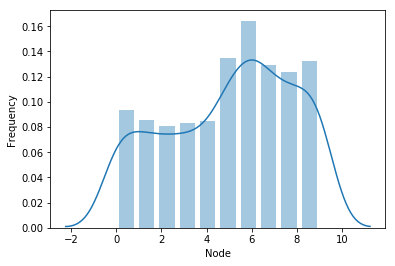

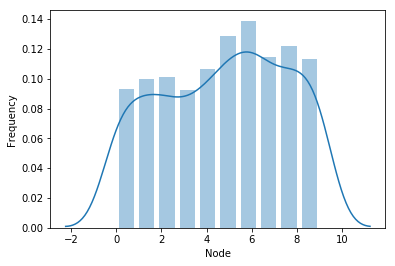

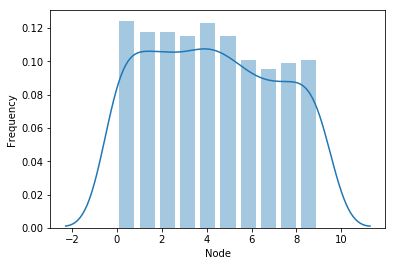

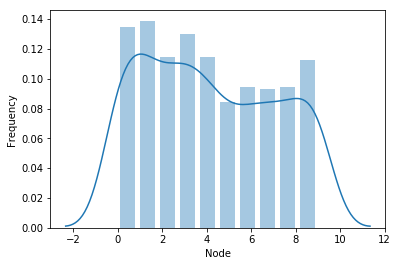

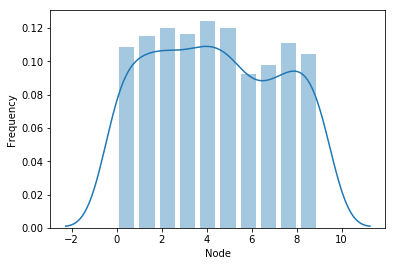

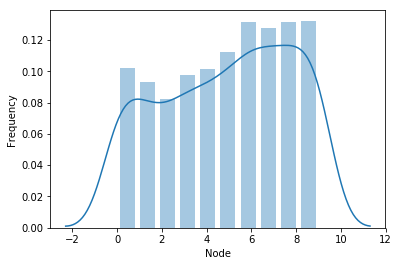

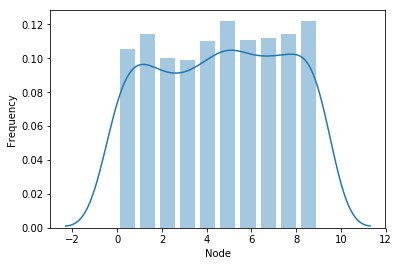

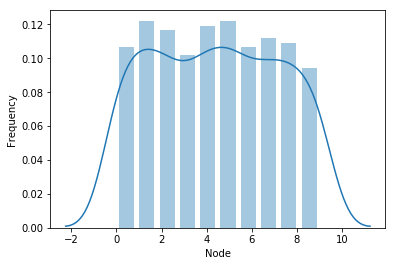

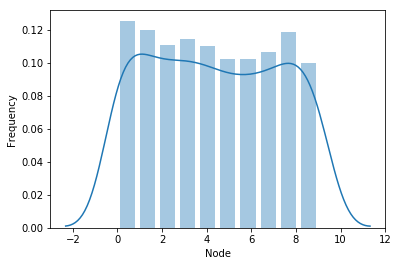

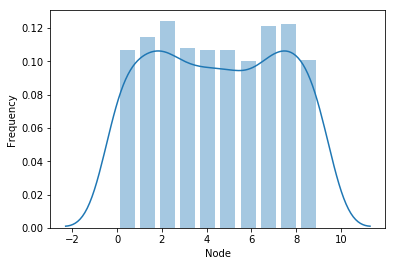

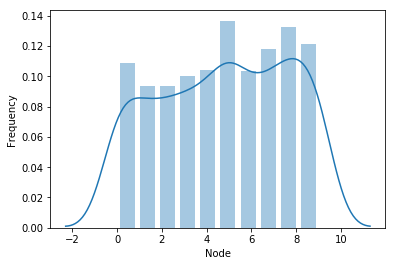

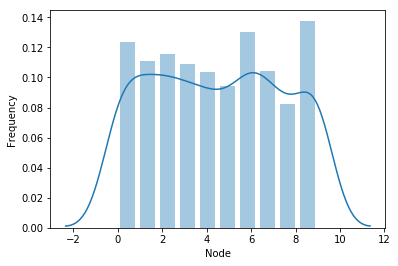

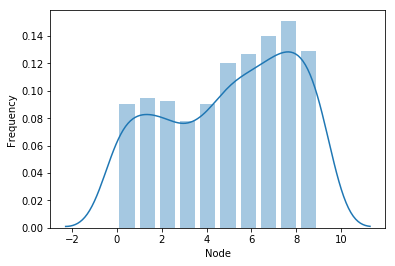

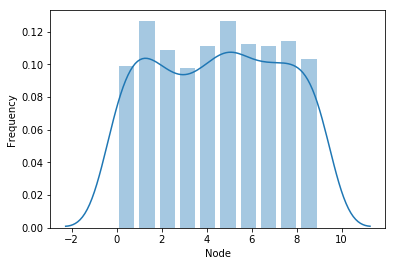

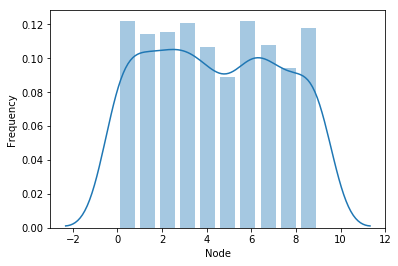

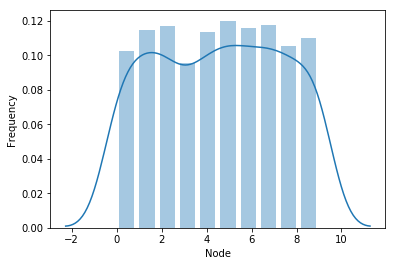

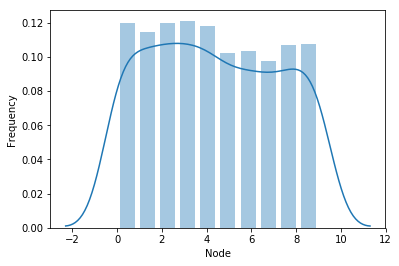

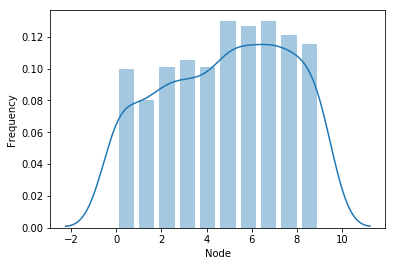

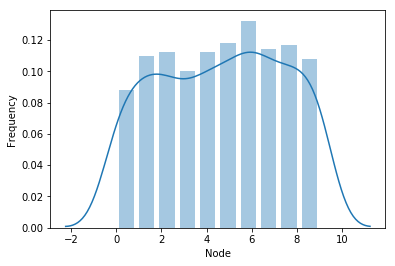

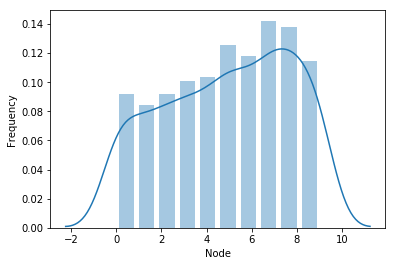

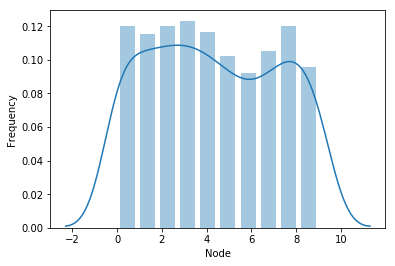

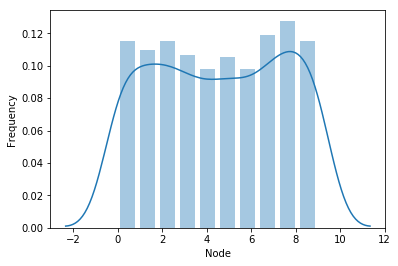

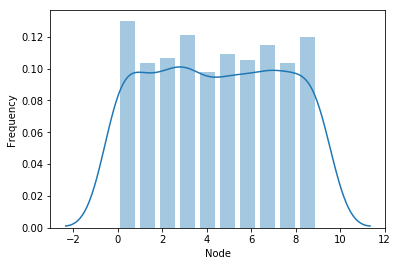

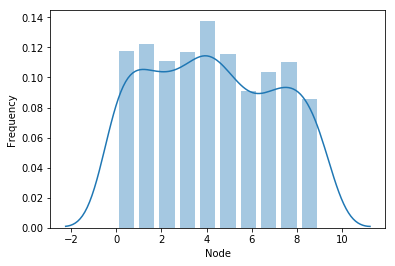

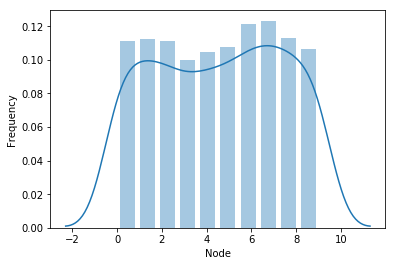

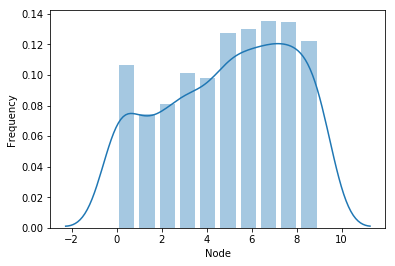

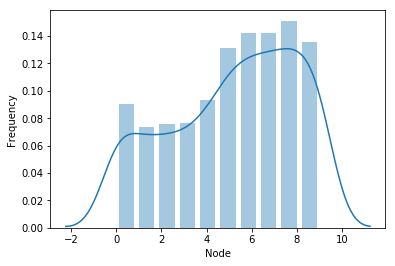

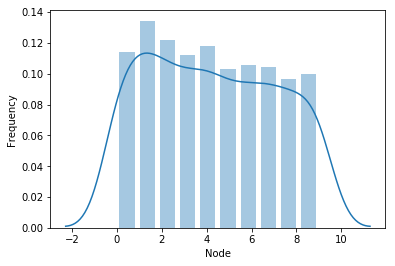

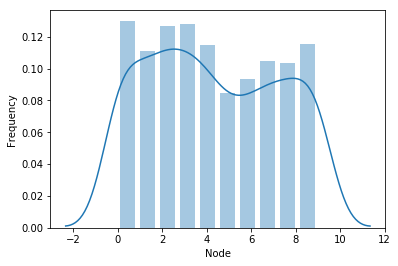

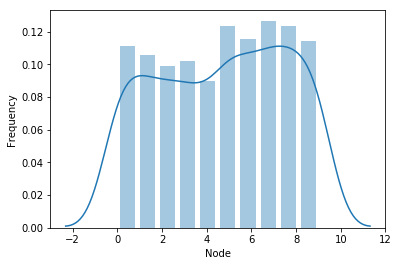

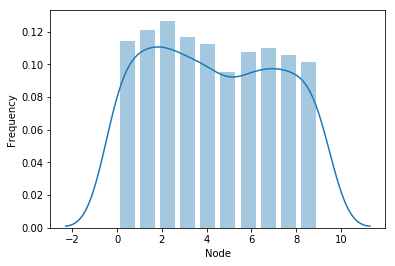

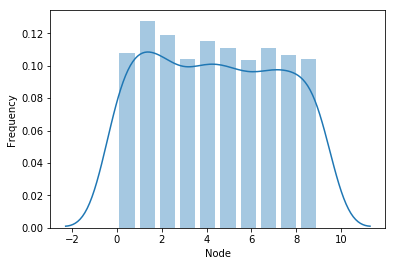

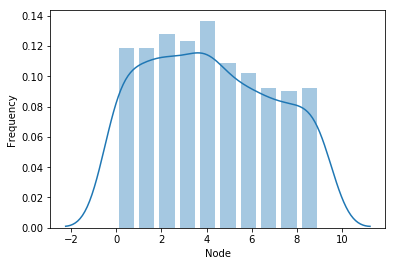

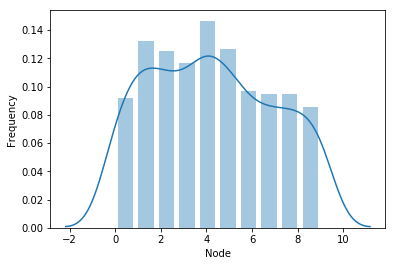

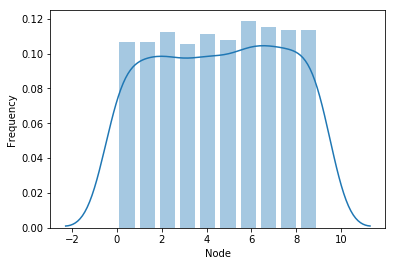

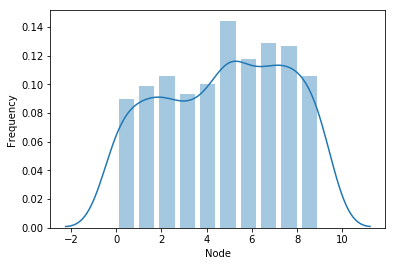

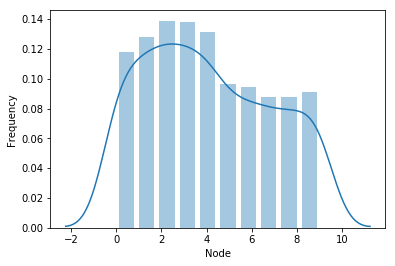

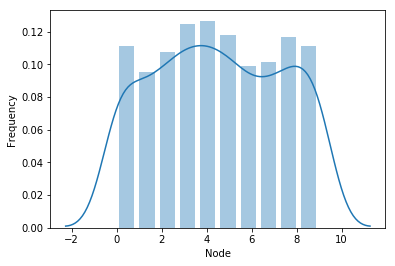

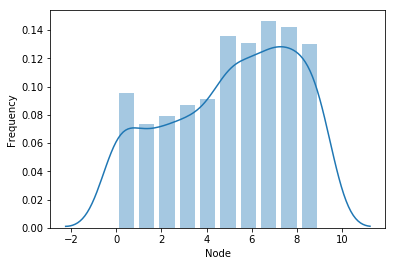

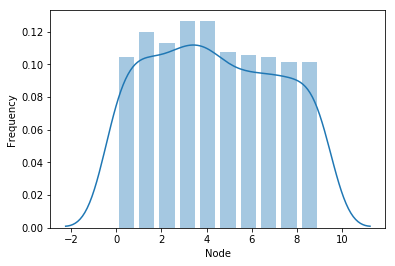

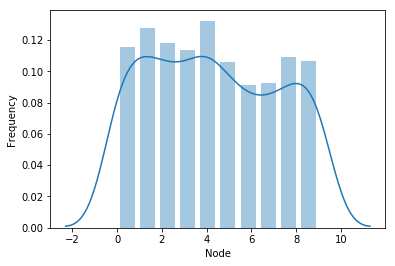

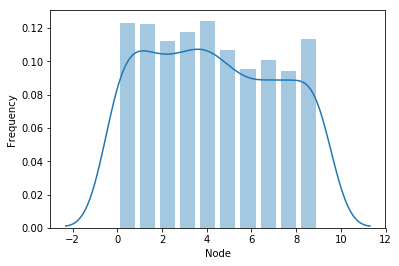

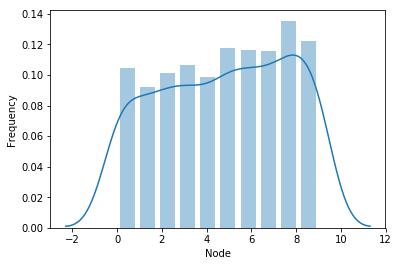

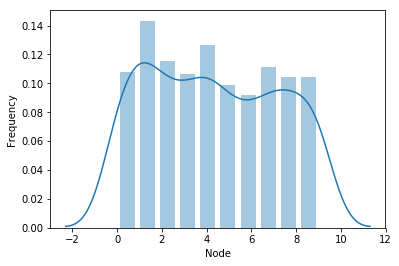

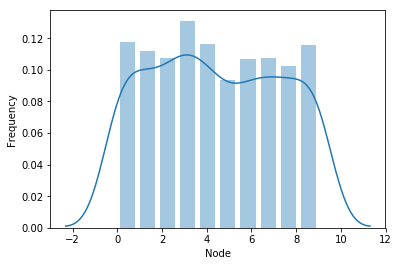

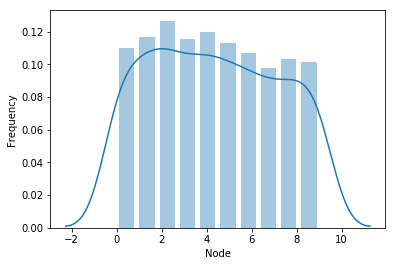

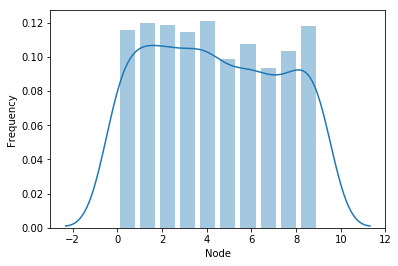

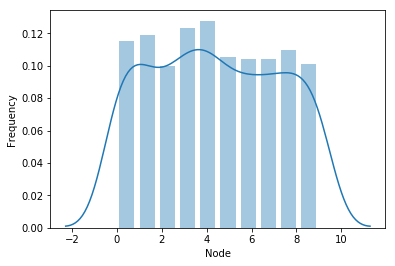

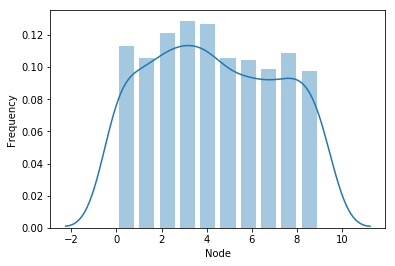

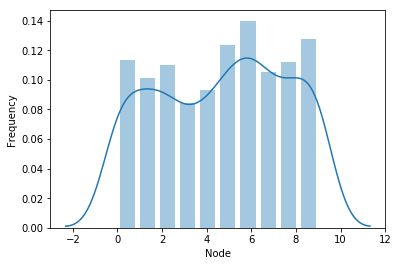

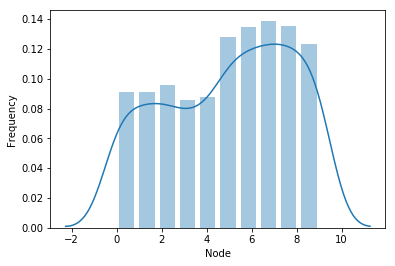

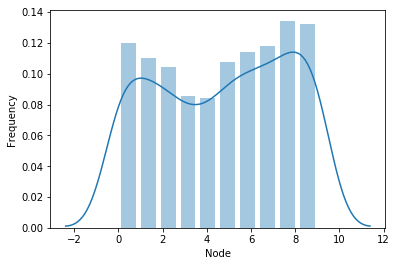

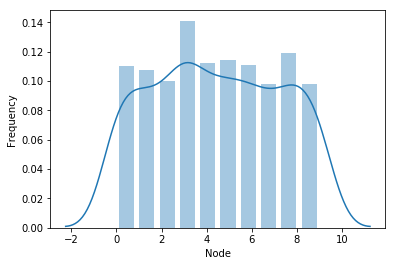

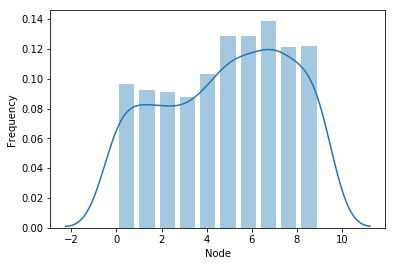

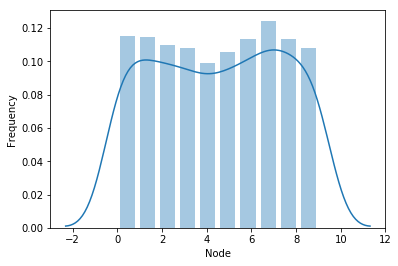

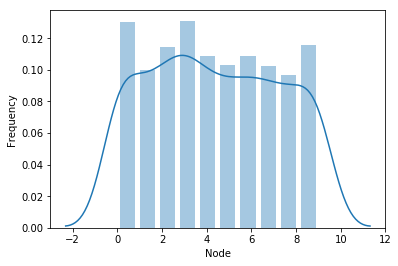

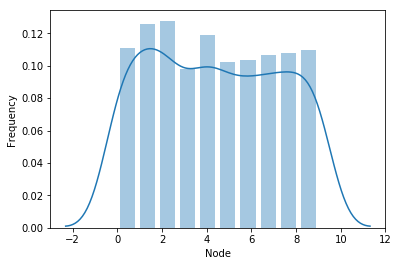

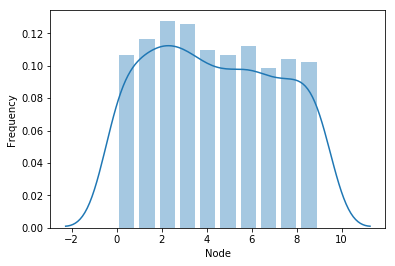

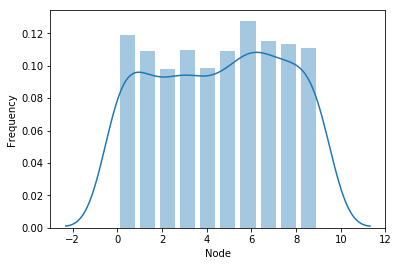

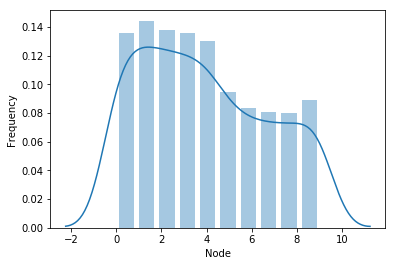

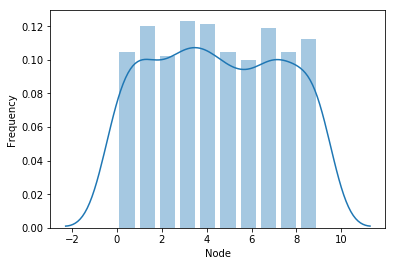

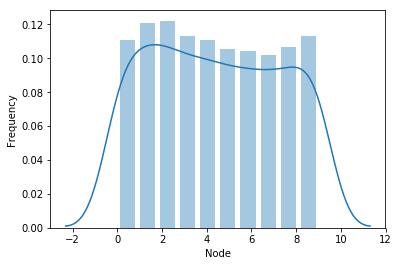

In [234]:

for i in range(100):
    walks = random_walk_wei(schapiro10_wei_uni,1000)

    # plot and save histogram of walk
    fig = plt.figure()
    sns.distplot(walks, bins=10, hist_kws={"rwidth":0.75})
    plt.xlabel('Node')
    plt.ylabel('Frequency')

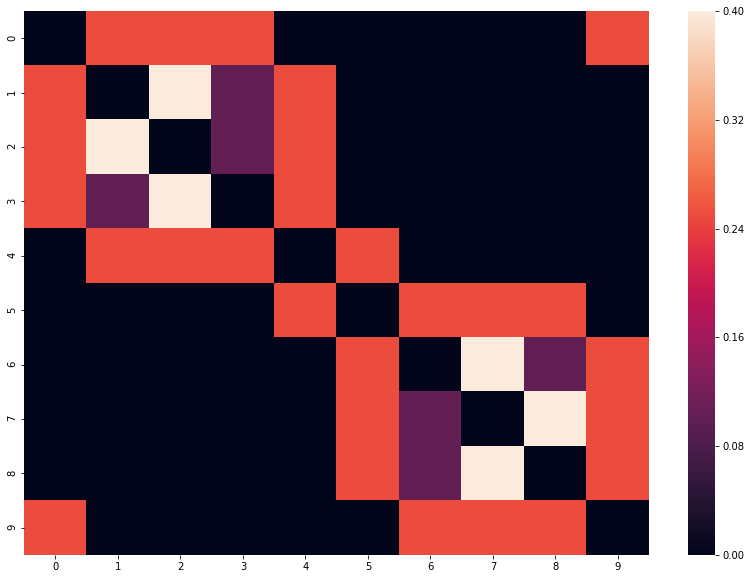

In [189]:
A = nx.adjacency_matrix(schapiro10_wei)

fig = plt.figure(figsize=(14,10))
sns.heatmap(A.todense())


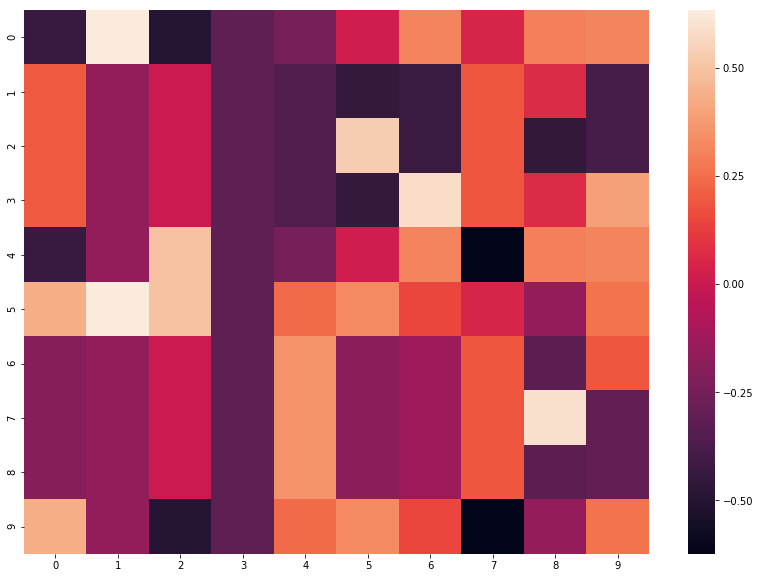

In [190]:
[w, v] = np.linalg.eig(A.todense())

fig = plt.figure(figsize=(14,10))
sns.heatmap(v)

In [192]:
w

array([-0.59307033, -0.25      ,  0.25      ,  1.        ,  0.84307033,
       -0.4       , -0.1       , -0.25      , -0.4       , -0.1       ])

In [8]:
# Add edges
schapiro10_test = nx.DiGraph()
schapiro10_test.add_edges_from([(1,2), (8,7), (6,7), (3,2)], weight=0.7)
schapiro10_test.add_edges_from([(6,8), (6,9), (6,5), (8,9), (8,6), (8,5), (1,3), (1,4), (1,0), (3,1),
                                (3,4), (3,0)], weight=0.1)
schapiro10_test.add_edges_from([(0,1), (0,2), (0,3), (0,9), (4,2), (4,1), (4,3), (4,5),
                                (9,6), (9,7), (9,0), (9,8), (5,6), (5,8), (5,7), (5,4),
                                (2,1), (2,0), (2,3), (2,4), (7,5), (7,6), (7,8), (7,9)], weight=0.25)
edges = schapiro10_test.edges
colors = []
for e in edges:
    colors.append(schapiro10_test.get_edge_data(e[0],e[1]).get('weight'))
    
list(schapiro10_test.edges(data='weight'))

[(0, 1, 0.25),
 (0, 2, 0.25),
 (0, 3, 0.25),
 (0, 9, 0.25),
 (1, 0, 0.1),
 (1, 2, 0.7),
 (1, 3, 0.1),
 (1, 4, 0.1),
 (2, 0, 0.25),
 (2, 1, 0.25),
 (2, 3, 0.25),
 (2, 4, 0.25),
 (3, 0, 0.1),
 (3, 1, 0.1),
 (3, 2, 0.7),
 (3, 4, 0.1),
 (4, 1, 0.25),
 (4, 2, 0.25),
 (4, 3, 0.25),
 (4, 5, 0.25),
 (5, 8, 0.25),
 (5, 4, 0.25),
 (5, 6, 0.25),
 (5, 7, 0.25),
 (6, 8, 0.1),
 (6, 9, 0.1),
 (6, 5, 0.1),
 (6, 7, 0.7),
 (7, 8, 0.25),
 (7, 9, 0.25),
 (7, 5, 0.25),
 (7, 6, 0.25),
 (8, 9, 0.1),
 (8, 5, 0.1),
 (8, 6, 0.1),
 (8, 7, 0.7),
 (9, 0, 0.25),
 (9, 8, 0.25),
 (9, 6, 0.25),
 (9, 7, 0.25)]

In [9]:
pos=nx.spring_layout(schapiro10_test) # positions for all nodes
pos

labels={}
labels[0]=r'$0$'
labels[1]=r'$1$'
labels[2]=r'$2$'
labels[3]=r'$3$'
labels[4]=r'$4$'
labels[5]=r'$5$'
labels[6]=r'$6$'
labels[7]=r'$7$'
labels[8]=r'$8$'
labels[9]=r'$9$'


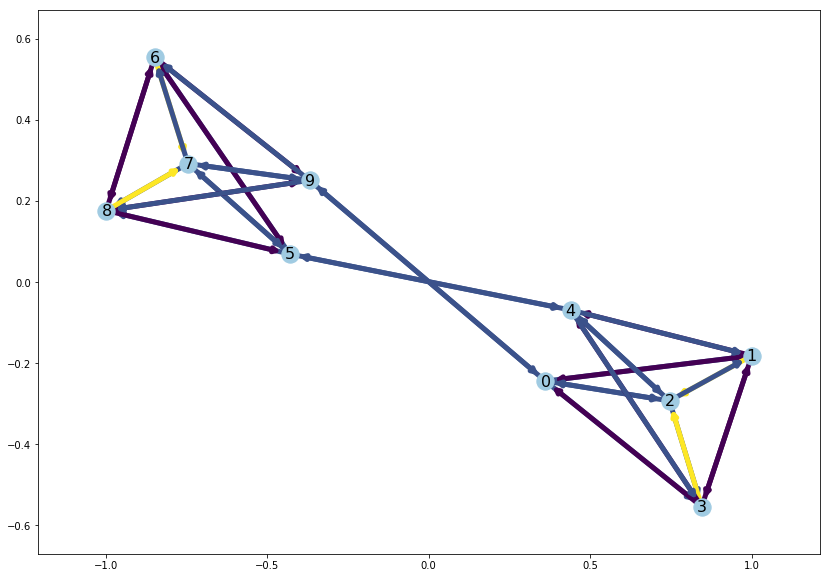

In [10]:
fig = plt.figure(figsize=(14,10))

# nodes
nx.draw_networkx_nodes(schapiro10_test,pos,node_color='#A0CBE2', with_labels=True)

# edges
nx.draw_networkx_edges(schapiro10_test,pos,edge_color=colors, width=5)

#labels
nx.draw_networkx_labels(schapiro10_test,pos,labels,font_size=16)

plt.show()

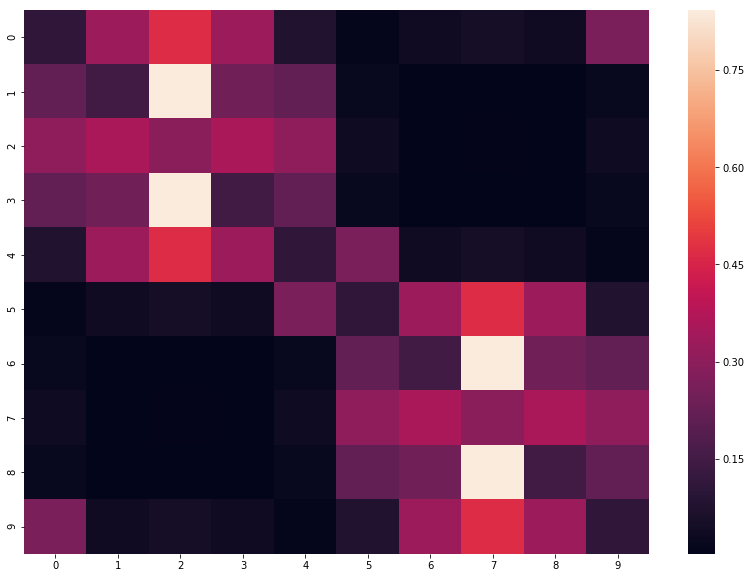

In [50]:
import seaborn as sns
import scipy as sp

A = nx.adjacency_matrix(schapiro10_test)

fig = plt.figure(figsize=(14,10))
sns.heatmap(sp.linalg.expm(A.todense()) - sp.eye(10))


Text(0,0.5,'Frequency')

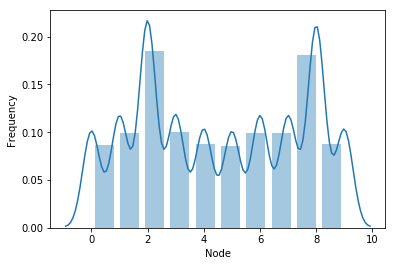

In [35]:
walks = random_walk_wei(schapiro10_test,100000)
fig = plt.figure()
sns.distplot(walks, bins=10, hist_kws={"rwidth":0.75})
plt.xlabel('Node')
plt.ylabel('Frequency')
#plt.savefig("".join(['/Users/stiso/Documents/Python/graphLearning/images/converge_hist.png']))
